# Initial Set Up

In [1]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian',
             'comp.graphics', 'sci.med', 'rec.sport.baseball']
             #             'comp.graphics', 'sci.med', 

mydata_train = fetch_20newsgroups(subset='train', shuffle=True, categories=categories, 
                                  remove = ('headers', 'footers', 'quotes'), random_state=42)

mydata_test = fetch_20newsgroups(subset='test', shuffle=True, categories=categories, 
                                  remove = ('headers', 'footers', 'quotes'), random_state=42)

print('size of training set: %s' % (len(mydata_train ['data'])))
print('size of validation set: %s' % (len(mydata_test['data'])))
print('classes: %s' % (mydata_train.target_names))

size of training set: 2854
size of validation set: 1899
classes: ['alt.atheism', 'comp.graphics', 'rec.sport.baseball', 'sci.med', 'soc.religion.christian']


In [2]:
import pandas as pd
mydata_train_df = pd.DataFrame({'data': mydata_train.data, 'target': mydata_train.target})
mydata_train_df.head(10)

,data,target
0,I know that there is MSG sensitivity. When I ...,3
1,"Okay, this is a long shot.\n\nMy friend Robin ...",3
2,"\nWhile we're on the multipurpose subject, le...",2
3,\netc. ...\n\n\nDyer is beyond rude. \n\nThere...,3
4,"Lowenstein is NOT Jewish. However, there is a...",2
5,[deletions]\n\nIf this is grounded firmly in I...,0
6,\n\n\n\n\n\nIf I remember correctly (Which is ...,2
7,"has no\nmitigate\nliterature,\n\nFirst, let me...",3
8,Excerpts from netnews.alt.atheism: 15-Apr-93 R...,0
9,\nWhy? Do you expect him to remain the best s...,2


In [3]:
seed = 777

# Labeled Training Data Set Up



In [4]:
X = mydata_train.data
y = mydata_train.target

#X_test = mydata_test.data
#y_test = mydata_test.target

Labeled Training Data: initially, we will have 25 labeled data.  5 for each category. 

In [5]:
import numpy as np
n_per_cat = 4
np.random.seed(seed)

initial_idx = []
for cat in range(5):
    initial_idx.append(mydata_train_df[mydata_train_df.target==cat][0:n_per_cat].index) 

initial_idx = [item for sublist in initial_idx for item in sublist]
X_train = [X[i] for i in initial_idx]
y_train = [y[i] for i in initial_idx]


Visual Check:

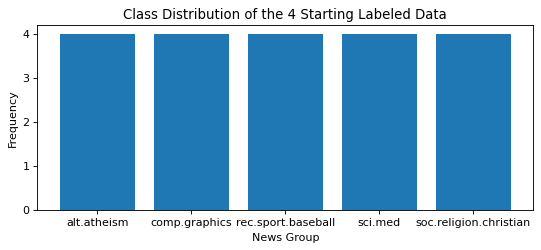

In [6]:
import numpy as np
targets, frequency = np.unique(y_train, return_counts=True)
targets, frequency

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(mydata_train.target_names, frequency)
plt.title('Class Distribution of the ' + str(n_per_cat) + ' Starting Labeled Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

Here is an SVM Model with Count Vectorizer and TF-IDF preprocessing. 

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#svm_clf = Pipeline([
      #  ('vect', CountVectorizer()),
      #  ('tfidf', TfidfTransformer()),
      #  ('clf', SVC(probability=True))])


rf_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier())])

How does the SVM of the fully labeled data perform?

In [8]:
full_data_model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier())])
full_data_model.fit(X, y).score(X, y)

0.9810791871058164

In [20]:
from sklearn import metrics
predicted = full_data_model.predict(X=X)
print(metrics.classification_report(mydata_train.target, predicted, target_names=mydata_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       1.00      0.97      0.99       480
         comp.graphics       1.00      0.97      0.99       584
    rec.sport.baseball       0.92      1.00      0.96       597
               sci.med       1.00      0.97      0.99       594
soc.religion.christian       1.00      0.98      0.99       599

              accuracy                           0.98      2854
             macro avg       0.98      0.98      0.98      2854
          weighted avg       0.98      0.98      0.98      2854



In [24]:
metrics.precision_recall_fscore_support(mydata_train.target, predicted)[0:2]

(array([1.        , 1.        , 0.91846154, 0.99827288, 1.        ]),
 array([0.975     , 0.97089041, 1.        , 0.97306397, 0.98497496]))

In [10]:
text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier())])
text_clf.fit(X_train, y_train).score(X, y)

0.2904695164681149

In [11]:
predicted = text_clf.predict(X=X)
print(metrics.classification_report(mydata_train.target, predicted, target_names=mydata_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.17      0.22      0.19       480
         comp.graphics       0.34      0.60      0.43       584
    rec.sport.baseball       0.43      0.11      0.18       597
               sci.med       0.38      0.23      0.29       594
soc.religion.christian       0.24      0.29      0.27       599

              accuracy                           0.29      2854
             macro avg       0.31      0.29      0.27      2854
          weighted avg       0.32      0.29      0.27      2854



# Random Sampling

In [ ]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

from modAL.models import ActiveLearner

random_learner = ActiveLearner(
    estimator=rf_clf,
    query_strategy=random_sampling,
    X_training=X_train, y_training=y_train)

current_learner = random_learner

In [ ]:
np.random.seed(seed)
# active learning
n_queries = 25
query_indices = []
accuracies = []
accuracies.append(current_learner.score(X=X, y=y))
for k in range(n_queries):
    query_idx, query_instance = current_learner.query(X)
    current_learner.teach([X[query_idx]], [y[query_idx]])
    query_indices.append(query_idx) 
    accuracies.append(current_learner.score(X=X, y=y))

In [ ]:
plt.rcParams["figure.figsize"] = (8, 3)
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")

In [ ]:
query_cat = mydata_train_df.iloc[query_indices, ].target

targets, frequency = np.unique(query_cat, return_counts=True)
targets, frequency


fig = plt.figure(figsize=(8, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(mydata_train.target_names, frequency)
plt.title('Class Distribution of the ' + str(n_queries) + ' queried observations')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn import metrics
predicted = current_learner.predict(X=X)
print(metrics.classification_report(mydata_train.target, predicted, target_names=mydata_test.target_names))

In [ ]:
current_learner.score(X, y)

In [ ]:
random_accuracy = accuracies
random_query_cat = query_cat

# Margin Sampling

In [ ]:
from modAL.uncertainty import margin_sampling

margin_learner = ActiveLearner(
    estimator=rf_clf,
    query_strategy=margin_sampling,
    X_training=X_train, y_training=y_train
)

In [ ]:
np.random.seed(seed)
# active learning
n_queries = 25
query_indices = []
accuracies = []
accuracies.append(margin_learner.score(X=X, y=y))
for k in range(n_queries):
    accuracies.append(margin_learner.score(X=X, y=y))
    query_idx, query_instance = margin_learner.query(X)
    margin_learner.teach([X[query_idx[0]]], [y[query_idx[0]]])
    query_indices.append(query_idx[0]) 

In [ ]:
plt.rcParams["figure.figsize"] = (8, 3)
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")

In [ ]:
query_cat = mydata_train_df.iloc[query_indices, ].target

targets, frequency = np.unique(query_cat, return_counts=True)
targets, frequency


fig = plt.figure(figsize=(8, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(mydata_train.target_names, frequency)
plt.title('Class Distribution of the ' + str(n_queries) + ' queried observations')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

In [ ]:
predicted = margin_learner.predict(X=X)
print(metrics.classification_report(mydata_train.target, predicted, target_names=mydata_test.target_names))

In [ ]:
margin_learner.score(X, y)

In [ ]:
margin_accuracy = accuracies
margin_query_cat = query_cat

# Entropy Sampling

In [ ]:
from modAL.uncertainty import entropy_sampling

entropy_learner = ActiveLearner(
    estimator=rf_clf,
    query_strategy=entropy_sampling,
    X_training=X_train, y_training=y_train
)
current_learner = entropy_learner

In [ ]:
np.random.seed(seed)
# active learning
n_queries = 25
query_indices = []
accuracies = []
accuracies.append(current_learner.score(X=X, y=y))
for k in range(n_queries):
    query_idx, query_instance = current_learner.query(X)
    current_learner.teach([X[query_idx[0]]], [y[query_idx[0]]])
    query_indices.append(query_idx[0]) 
    accuracies.append(current_learner.score(X=X, y=y))

In [ ]:
plt.rcParams["figure.figsize"] = (8, 3)
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")

In [ ]:
query_cat = mydata_train_df.iloc[query_indices, ].target

targets, frequency = np.unique(query_cat, return_counts=True)
targets, frequency


fig = plt.figure(figsize=(8, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(mydata_train.target_names, frequency)
plt.title('Class Distribution of the ' + str(n_queries) + ' queried observations')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

In [ ]:
predicted = current_learner.predict(X=X)
print(metrics.classification_report(mydata_train.target, predicted, target_names=mydata_test.target_names))

In [ ]:
current_learner.score(X, y)

In [ ]:
entropy_accuracy = accuracies
entropy_query_cat = query_cat

# How are they querying? 

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
f1, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})

# -------------------------------------------

ax[0].plot(random_accuracy, label="random sampling", alpha=0.5, lw=1)
ax[0].plot(margin_accuracy, label="margin sampling", alpha=0.5, lw=1)
ax[0].plot(entropy_accuracy, label="entropy sampling", alpha=0.5, lw=1)
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='upper left')

# -------------------------------------------
methods = [random_query_cat, margin_query_cat, entropy_query_cat]
ax[1].set_ylim(0, 1)
for method in methods:
    baseball_p = (np.cumsum(method==2))  / np.arange(1, n_queries+1)
    ax[1].plot(np.arange(n_queries), baseball_p, '.', alpha=0.5)


plt.show()
